<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Marco Antonio Ochoa Cárdenas

**Fecha:** 21/10/2021.

**Expediente** : if720072 
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/Marcoif/Proyecto_Conjunto_MAOchoa_RBetancourt.git

# Tarea 8: Clase 22

# <font color = 'red'> Tarea: </font>

Replicar el procedimiento anterior para valoración de opciones 'call', pero en este caso para opciones tipo 'put' y además deben de comparar con los resultados teoricos del método de valuación de Black-Scholes (ecuación del principio de clase)

# Codigo del estudiante 1

In [1]:
### Librerias  a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import yfinance as yf
from datetime import date
import seaborn as sns; sns.set();
%matplotlib inline
#algunas opciones para Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
# Función para descargar precios de cierre ajustados
def get_adj_closes(tickers, start_date = None, end_date = None):
    closes = web.DataReader(name = tickers, data_source = "yahoo", start = start_date, end = end_date)
    closes = closes["Adj Close"]
    closes.sort_index(inplace = True)
    return closes

def daily_ret(closes):
    return np.log(closes / closes.shift(1)).iloc[1:]

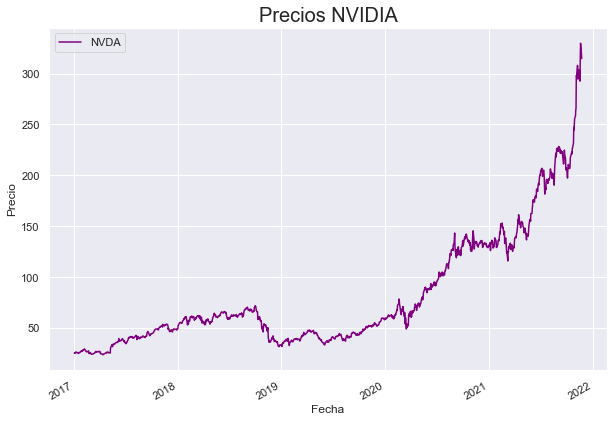

In [3]:
ticker = ['NVDA']
start_date = '2017-01-01' 

closes_nvda = get_adj_closes(ticker, start_date)
closes_nvda.plot(figsize=(10,7), xlabel='Fecha', ylabel='Precio', color='Purple');
plt.title('Precios NVIDIA', fontsize=20)
plt.legend(ticker);

In [4]:
def calc_daily_ret(closes:"Cierres de los precios descargados"):
    "Esta función retorna los rendimientos logaritmicos diarios de los cierres del activo recibido"
    return np.log(closes/closes.shift(1)).iloc[1:]

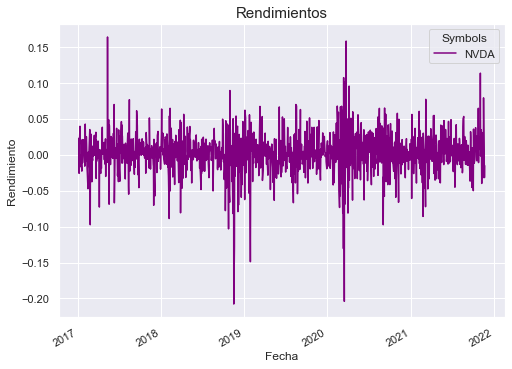

In [5]:
ret_nvda = calc_daily_ret(closes_nvda)### Se genera una variable donde se guardan los rendimientos diarios
ret_nvda.plot(figsize=(8,6), xlabel = 'Fecha', ylabel='Rendimiento', color='purple');
plt.title('Rendimientos', fontsize=15);

In [6]:
import requests

def obtener_datos_opciones(symbol):
    headers = headers = {
            'Connection': 'keep-alive',
            'Expires': str(-1),
            'Upgrade-Insecure-Requests': str(1),
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36'
    }
    url = f'https://query1.finance.yahoo.com/v7/finance/options/{symbol}'
    r = requests.get(url, headers=headers)
    dates = r.json()['optionChain']['result'][0]['expirationDates']
    
    calls = []
    puts = []
    
    for d in dates:
        res = requests.get(url + f'?date={d}', headers=headers)
        calls += res.json()['optionChain']['result'][0]['options'][0]['calls']
        puts += res.json()['optionChain']['result'][0]['options'][0]['puts']

    for c in calls:
        c['type'] = 'call'
        c['lastTradeDate'] = pd.to_datetime(c['lastTradeDate']*1000000000)
        c['expiration'] = pd.to_datetime(c['expiration']*1000000000)
    for p in puts:
        p['type'] = 'put'
        p['lastTradeDate'] = pd.to_datetime(p['lastTradeDate']*1000000000)
        p['expiration'] = pd.to_datetime(p['expiration']*1000000000)
    
    return pd.DataFrame(calls + puts)

In [7]:
nvda_opt = obtener_datos_opciones('NVDA')
nvda_opt

,contractSymbol,strike,currency,...,impliedVolatility,inTheMoney,type
0,NVDA211126C00110000,110.0,USD,...,1.000e-05,True,call
1,NVDA211126C00115000,115.0,USD,...,1.000e-05,True,call
2,NVDA211126C00120000,120.0,USD,...,1.000e-05,True,call
3,NVDA211126C00125000,125.0,USD,...,1.000e-05,True,call
4,NVDA211126C00130000,130.0,USD,...,1.000e-05,True,call
...,...,...,...,...,...,...,...
3735,NVDA240119P00500000,500.0,USD,...,4.680e-01,True,put
3736,NVDA240119P00520000,520.0,USD,...,4.678e-01,True,put
3737,NVDA240119P00540000,540.0,USD,...,4.691e-01,True,put
3738,NVDA240119P00580000,580.0,USD,...,4.708e-01,True,put


In [8]:
K = 450
indice_opt = nvda_opt.loc[(nvda_opt.type=='put') & (nvda_opt.strike==K) & (nvda_opt.expiration=='2023-01-20')]
indice_opt

,contractSymbol,strike,currency,...,impliedVolatility,inTheMoney,type
3387,NVDA230120P00450000,450.0,USD,...,0.502,True,put


In [9]:
### Se accede a la información de la opción put escogida para observar el lastprice el cuál es el que se pretende aproximar
i_opt= indice_opt.index
opcion_valuar = nvda_opt.loc[i_opt[0]]
opcion_valuar

contractSymbol       NVDA230120P00450000
strike                             450.0
currency                             USD
lastPrice                          155.1
change                             -2.33
                            ...         
expiration           2023-01-20 00:00:00
lastTradeDate        2021-11-23 14:45:19
impliedVolatility                  0.502
inTheMoney                          True
type                                 put
Name: 3387, Length: 16, dtype: object

In [10]:
mu = ret_nvda.mean()[0] 
sigma = ret_nvda.std()[0] 
print(f' Rendimientos diarios con media: {mu} y desviación estandar: {sigma}')

 Rendimientos diarios con media: 0.0020503811753476656 y desviación estandar: 0.029545729758644675


In [11]:
# Tasa de bonos 
r = 0.0018/360 # Tasa diaria

### Valuación de la prima put sobre el activo NVDA de manera análitica
**Método Black-Sholes**

Para opciones `put`:
$$
\text{Valor actual de la opción} = V(S_0, T) = K e^{-r*T} N(-d_2) - S_0 N(-d_1)  
$$

$$
d_1 = \frac{\ln{\frac{S_0}{K}} + (r + \sigma^2 / 2) T}{\sigma \sqrt{T}}, \quad d_2 = \frac{\ln{\frac{S_0}{K}} + (r - \sigma^2 / 2) T}{\sigma \sqrt{T}} 
$$

se calcula $d_1$ y $d_2$:

$$
d_1 = \frac{\ln{\frac{311.45}{450}} + (\frac{0.0018}{360} + \frac{0.02955^2}{2}) 423}{0.02955 \sqrt{423}} = -0.2981, \quad d_2 = \frac{\ln{\frac{311.45}{450}} + (\frac{0.0018}{360} - \frac{0.02955^2}{2}) 423}{0.02955 \sqrt{423}} = -0.9059
$$

De acuerdo a la tabla Z o al comando st.norm.cdf() de d1 y d2 se tiene que $$ N(-d_1) = 0.6141  $$ y $$ N(-d_2) = 0.8159$$ 

Entonces, podemos valuar la opción put:

$$
V(S_0, T) = K e^{-r*T} N(-d_2) - S_0 N(-d_1) 
$$
$$
V(311.45, 423) = (450) e^{-(\frac{0.0018}{360})*423}(0.8159) - (311.45)(0.6141) = 175.11
$$

In [12]:
today = pd.Timestamp(date.today()) 
expiry = opcion_valuar.expiration 
K = 450
dates = pd.date_range(start=today, end=expiry, freq='B')

ndays = len(dates)
nscen = 100000 

S0 = closes_nvda.iloc[-1,0]  

sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)

sim_closes = S0*np.exp(sim_ret.cumsum())

sim_closes.iloc[0,:] = S0
sim_closes

,0,1,2,...,99997,99998,99999
2021-11-23,314.780,314.780,314.780,...,314.780,314.780,314.780
2021-11-24,299.263,306.475,322.144,...,320.562,306.452,308.093
2021-11-25,295.909,314.231,320.523,...,317.316,290.342,300.112
2021-11-26,300.187,292.225,329.651,...,324.948,298.494,322.178
2021-11-29,296.472,298.102,338.434,...,324.129,290.500,331.855
...,...,...,...,...,...,...,...
2023-01-16,159.614,230.025,443.033,...,385.180,323.959,369.379
2023-01-17,159.896,239.433,437.380,...,392.741,309.240,365.671
2023-01-18,150.622,235.187,431.245,...,394.653,284.778,365.617
2023-01-19,149.328,225.786,452.767,...,393.923,287.096,350.094


<AxesSubplot:>

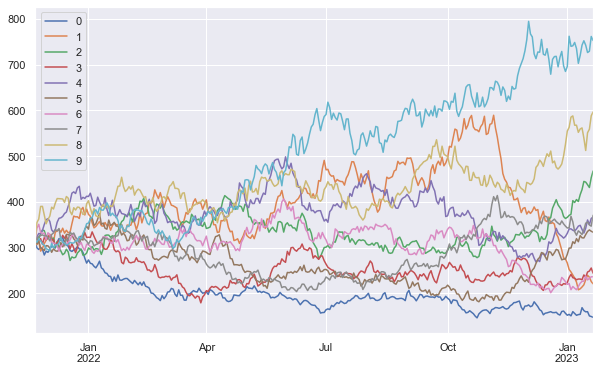

In [13]:
sim_closes.iloc[:,:10].plot(figsize=[10,6])

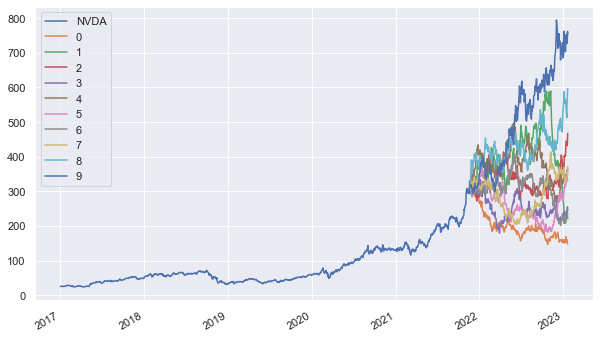

In [14]:
pd.concat([closes_nvda,sim_closes.iloc[:,:10]]).plot(figsize=[10,6]);

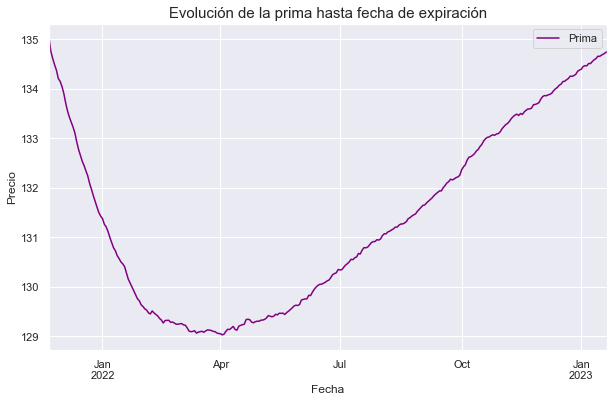

In [15]:
###Se genera una matriz con el valor del strike price
strike = pd.DataFrame(K*np.ones([ndays,nscen]), index=dates)


put = pd.DataFrame({'Prima':np.exp(-r*ndays) \
              *np.fmax(strike - sim_closes,0).mean(axis=1)}, index=dates)
put.plot(figsize=(10,6), xlabel = 'Fecha', ylabel='Precio', color='purple');
plt.title('Evolución de la prima hasta fecha de expiración', fontsize=15);

In [16]:
### Se obtiene el precio de la prima a fecha de expiración, ósea la opción a valuar
print(f'Este es el valor de la prima a fecha de expiración: {put.iloc[-1][0]}')

Este es el valor de la prima a fecha de expiración: 134.74617115274577


In [17]:
###Intervalo de confianza
confianza = 0.99
sigma_est = sim_closes.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(f'La prima es {put.iloc[-1][0]} está en el intervalo{i2} con una confianza del 99%')

La prima es 134.74617115274577 está en el intervalo(133.1343078904903, 136.35803441500124) con una confianza del 99%


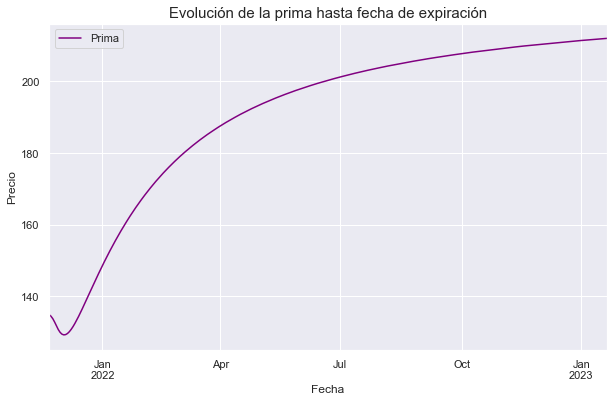

In [18]:
#Modelo reduccion de varianza
U = (np.arange(0,nscen)+np.random.randn(ndays,nscen)) /nscen
Z = st.norm.ppf(U)

sim_ret2 = pd.DataFrame(sigma*Z+r,index=dates)
sim_closes2 = S0*np.exp(sim_ret2.cumsum())

# Función de pago
strike = pd.DataFrame(K*np.ones([ndays,nscen]), index=dates) 
put = pd.DataFrame({'Prima':np.exp(-r*ndays) \
              *np.fmax(strike - sim_closes2,0).T.mean()}, index=dates)
put.plot(figsize=(10,6), xlabel = 'Fecha', ylabel='Precio', color='purple');
plt.title('Evolución de la prima hasta fecha de expiración', fontsize=15);

In [19]:
print(f'Este es el valor de la prima a fecha de expiración: {put.iloc[-1][0]} con reducción de varinza')

Este es el valor de la prima a fecha de expiración: 211.9678905034849 con reducción de varinza


In [20]:
confianza = 0.99
sigma_est = sim_closes2.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(f'La prima es {put.iloc[-1][0]} está en el intervalo{i2} con una confianza del 99%')

La prima es 211.9678905034849 está en el intervalo(-60941154154236.164, 60941154154660.1) con una confianza del 99%


Text(0.5, 1.0, 'Histograma de los rendimientos de NVIDIA')

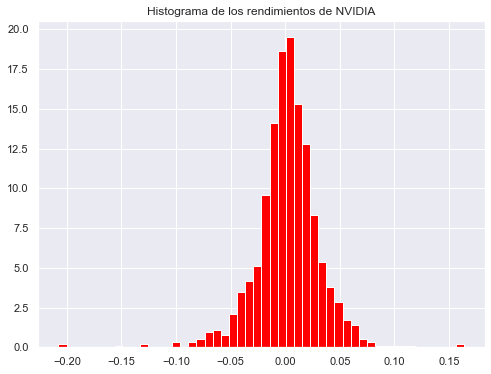

In [21]:
plt.figure(figsize=[8,6])
plt.hist(ret_nvda, bins=50, density=True, color='red')
plt.title('Histograma de los rendimientos de NVIDIA')

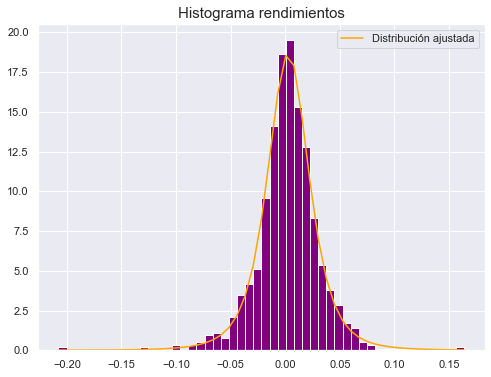

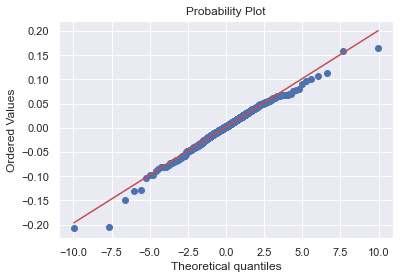

In [22]:
# Histograma de los rendimientos
plt.figure(figsize=[8,6])
y, x, _ = plt.hist(ret_nvda['NVDA'], bins=50, density=True, color='purple')
plt.title('Histograma rendimientos', fontsize=15)

# Se ajustan los parámetros de una distribución
dist = 't'
params = getattr(st, dist).fit(ret_nvda.values) 

# Generación de la pdf de la distribución ajustado con los parámetros encontrados
curve_fit = getattr(st, dist).pdf(x, *params)
plt.plot(x, curve_fit, label='Distribución ajustada', color='orange')
plt.legend()
plt.show()

# Q-Q
st.probplot(ret_nvda['NVDA'], sparams=params[:-2], dist=dist, plot=plt);

In [23]:
K = 450 
ndays = len(dates)
nscen = 100000

# Histograma tomando la tasa libre de riesgo
freq, values = np.histogram(ret_nvda+r-mu, bins=2000, density=True)
prob = freq/np.sum(freq) 

# Simulación de los rendimientos
ret = np.random.choice(values[1:], ndays*nscen, p=prob)

S0 = closes_nvda.iloc[-1,0]

# Simulación de precios
sim_ret_hist = pd.DataFrame(ret.reshape((ndays,nscen)),index=dates)
sim_closes_hist = S0 * np.exp(sim_ret_hist.cumsum())

sim_closes_hist.iloc[0,:] = S0
sim_closes_hist

,0,1,2,...,99997,99998,99999
2021-11-23,314.780,314.780,314.780,...,314.780,314.780,314.780
2021-11-24,313.381,331.044,306.753,...,313.206,289.685,333.949
2021-11-25,306.555,324.617,310.223,...,319.825,297.793,334.229
2021-11-26,301.386,336.131,317.251,...,315.194,309.217,335.694
2021-11-29,299.460,347.471,330.709,...,321.735,304.569,353.924
...,...,...,...,...,...,...,...
2023-01-16,559.536,258.043,437.796,...,977.785,405.220,225.804
2023-01-17,570.406,240.424,431.857,...,1024.773,399.574,221.667
2023-01-18,567.183,246.190,439.184,...,1008.994,400.430,217.929
2023-01-19,582.192,243.393,448.049,...,990.876,397.428,223.447


<AxesSubplot:>

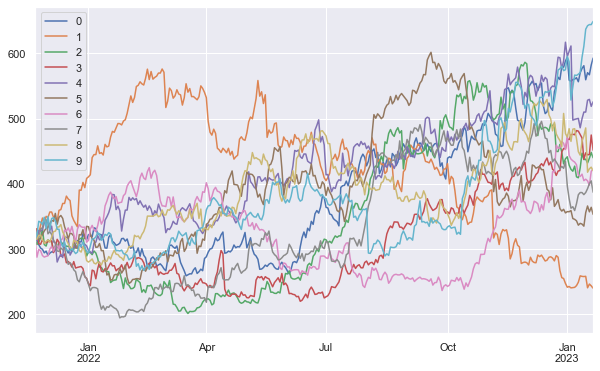

In [24]:
sim_closes_hist.iloc[:,:10].plot(figsize=[10,6])

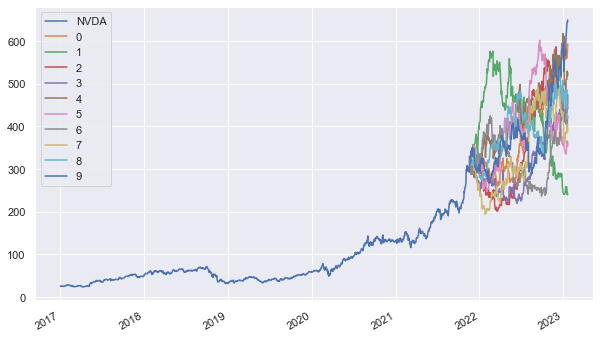

In [25]:
pd.concat([closes_nvda,sim_closes_hist.iloc[:,:10]]).plot(figsize=[10,6]);

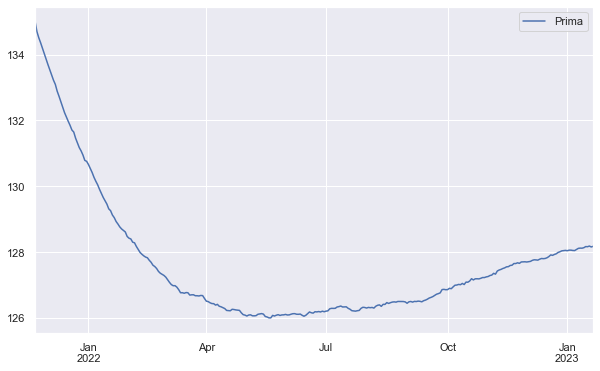

In [26]:
strike = pd.DataFrame(K*np.ones(ndays*nscen).reshape((ndays,nscen)), index=dates)###Se hace un vector constante del strike
put_hist = pd.DataFrame({'Prima':np.exp(-r*ndays) \
                          *np.fmax(strike-sim_closes_hist,0).T.mean()}, index=dates)###Se hace un df con la valuació diaria
put_hist.plot(figsize=[10,6]);             

In [27]:
put_hist.iloc[-1]###Se muestra el precio a la expiración de la prima
print(f'Este es el valor de la prima a fecha de expiración: {put_hist.iloc[-1][0]}')

Este es el valor de la prima a fecha de expiración: 128.16664130878934


In [28]:
confianza = 0.95###Se define un intervalo de confianza
sigma_est = sim_closes_hist.iloc[-1].sem()###Se toma la desviación de lo datos
mean_est = put_hist.iloc[-1].Prima###Se toma la media de los datos
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)###Se define el intervalo de confianza para t
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)###Se define en intervalo de confianza para la normal
print(i1)
print(i2)

(126.9104991373674, 129.42278348021128)
(126.9105143414178, 129.4227682761609)


### Conclusion

Ante los modelos podemos decir que el metodo de B&S es el mas efectivo a la hora de valuar una opcion, en este caso del tipo put debido a que con estas simulaciones s epuede dver como es que es el valor mas cercano a la prima real que se encuentra en los datos de cualquier paginad e internet referenciada a la accion que evaluamos 